In [1]:
import dinkum
from dinkum.vfg import Gene, Receptor
from dinkum.vfn import Tissue
#from dinkum import Timecourse

from dinkum.display import MultiTissuePanel, tc_record_activity

In [2]:
dinkum.reset()

In [3]:
# define a Gene with name 'X', assign it to variable 'x' in Python
x = Gene(name='X')

In [4]:
# define another Gene with name 'Y', assign it to variable 'y' in Python
y = Gene(name='Y')

In [5]:
# create a Tissue, and add genes to it.
m = Tissue(name='M')

start=1 stop=5


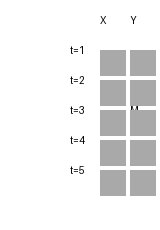

In [6]:
# run for 5 ticks (1 to 5)
dinkum.run_and_display(stop=5)
#states, tissues, is_active_fn = tc_record_activity(stop=5)

Underwhelming, ehh? We haven't turned any genes on!

@CTB why is M where it is...

In [7]:
# turn 'x' on in tissue m starting at time t
x.is_present(where=m, start=1)
# @CTB shouldn't M be a tissue name, rather than a tissue object?

start=1 stop=5


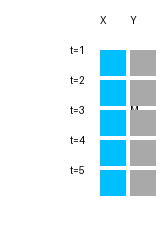

In [8]:
# run for 5 ticks (1 to 5)
dinkum.run_and_display(stop=5)

Still underwhelming - we haven't defined any regulatory relationships!

start=1 stop=5


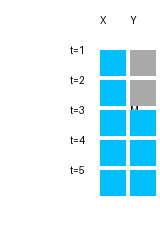

In [9]:
dinkum.reset()

x = Gene(name='X')
y = Gene(name='Y')
m = Tissue(name='M')

x.is_present(where=m, start=1)

# now define a regulatory relationship!
y.activated_by(source=x, delay=2)

# run for 5 ticks (1 to 5)
dinkum.run_and_display(stop=5)

## Cell-autonomous interactions

There are many possible gene-gene interactions *within* a cell.

We've already seen two - `is_present(where=tissue, start=None, duration=None)` and `activated_by(source, delay=1)`.

Here's their description:

* `is_present(where=tissue, start=None, duration=None)` - this gene is constitutively "on" from tick `start` for duration `duration`.
* `activated_by(source, delay=1)` - `source` is an upstream activator that acts at the given delay (in ticks).

Here are the remaining cell autonomous gene interactions that we have implemented:

* `activated_or(sources=[...], delay=1)` - `sources` is a list of upstream activators, any one of which suffices to activate this gene.
* `and_not(activator=..., repressor=..., delay=1)` - `actvator` activates unless `repressor` is active.
* `activated_by_and(sources=[...], delay=1)` - `sources` is a list of upstream activators, all of which must be present to activate this gene.
* `toggle_repressed(tf=..., cofactor=..., delay=1)` - this gene is repressed if `tf` is absent, or if `tf` is present without `cofactor`; it is active if both`tf` and `cofactor` are present. **@CTB isn't this basically the same as activated_by_and?**


## Side note: introducing multiple regulatory influences via lists

`activated_or` and `activated_by_and` both take *lists* of genes, as opposed to a single gene. The notation is used as below for `z`:

start=1 stop=7


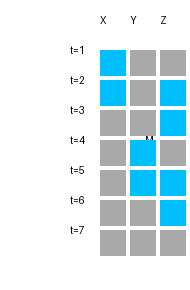

In [10]:
dinkum.reset()

# @CTB allow updating of rules instead of resetting?
x = Gene(name='X')
y = Gene(name='Y')
z = Gene(name='Z')
m = Tissue(name='M')

x.is_present(where=m, start=1, duration=2)
y.is_present(where=m, start=4, duration=2)

z.activated_or(sources=[x, y])

# run for 7 ticks
dinkum.run_and_display(stop=7)

## Interactions across cells/tissues

@CTB explain we only have concept of tissues


start=1 stop=10


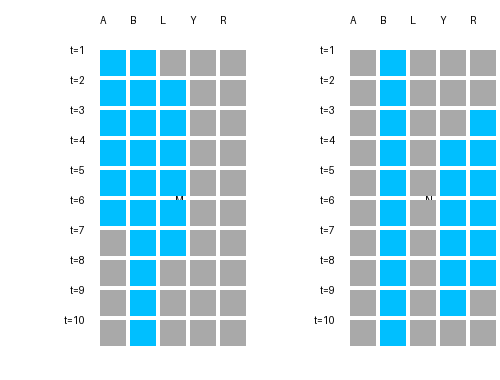

In [11]:
dinkum.reset()

# two tissues                                                               
m = Tissue(name='M')
n = Tissue(name='N')

# neighbors                                                                 
m.add_neighbor(neighbor=n)
n.add_neighbor(neighbor=m)

a = Gene(name='A')          # transient input in M to turn on ligand L      

m.add_gene(gene=a, start=1, duration=6)

b = Gene(name='B')          # permanent input in M and N to turn on receptor R                                                                             
m.add_gene(gene=b, start=1)
n.add_gene(gene=b, start=1)

# VFG:                                                                      
ligand = Gene(name='L')          # ligand                                   
r = Receptor(name='R')      # receptor                                      
y = Gene(name='Y')                        

ligand.activated_or(sources=[a])

r.ligand(activator=b, ligand=ligand) # expression driven by B,              
                                     # activated by ligand                  
y.activated_by(source=r)    # transcription of Y turned on by activated R.  

dinkum.run_and_display(stop=10)

# @CTB should Y be on in M?